# Лабораторная работа №4. Задача классификации

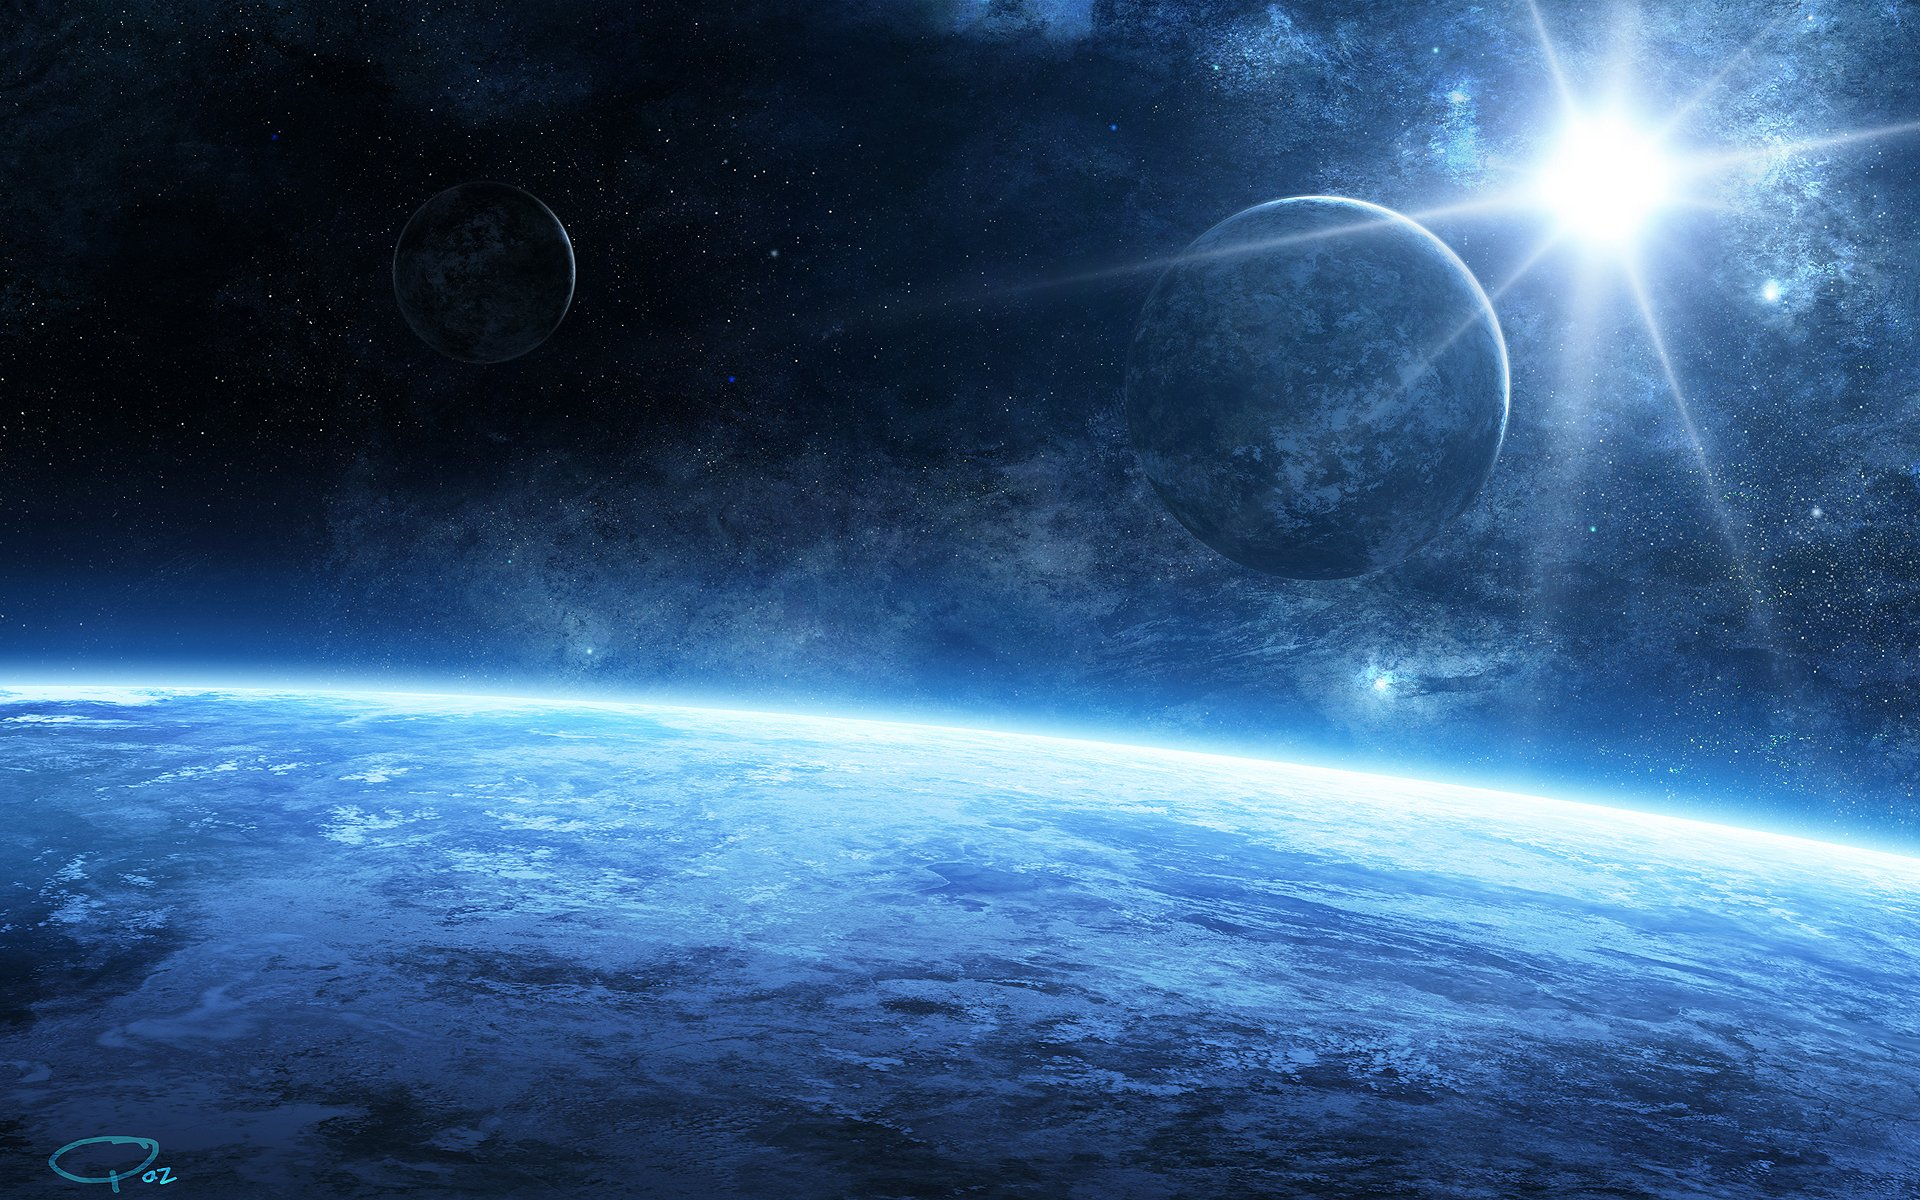

# Задание с примера (погода)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import statistics
from math import sqrt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [33]:
weather = [
        ('солнечно', True),
        ('снег', False),
        ('облачно', False),
        ('дождь', False),
        ('солнечно', True),
        ('снег', False),
        ('облачно', True),
        ('снег', False),
        ('солнечно', False),
        ('облачно', True),
        ('снег', True),
        ('солнечно', True),
        ('дождь', False),
        ('дождь', True),
        ('облачно', True),
]
weather_data = pd.DataFrame(weather, columns=['weather', 'stroll'])
weather_data

,weather,stroll
0,солнечно,True
1,снег,False
2,облачно,False
3,дождь,False
4,солнечно,True
5,снег,False
6,облачно,True
7,снег,False
8,солнечно,False
9,облачно,True


In [34]:
rain_if_stroll = len(weather_data.loc[(weather_data['weather'] == 'дождь') & (weather_data['stroll'] == True)]) / len(weather_data.loc[weather_data['stroll'] == True])

In [35]:
stroll_if_rain = ((len(weather_data.loc[weather_data['stroll'] == True]) / len(weather_data))*rain_if_stroll)/(len(weather_data.loc[weather_data['weather'] == 'дождь']) / len(weather_data))
stroll_if_rain

0.3333333333333333

## Этап 1. Предобработка данных

In [36]:
path='neo_task.csv'
hazaurdous_obj=pd.read_csv(path)

In [37]:
hazaurdous_obj.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'absolute_magnitude',
       'hazardous'],
      dtype='object')

Данный датасет содержит в себе следующие данные:
id - идентификатор объекта (числовое значение)

name - имя объекта (строка)

est_diameter_min - Минимальный расчетный диаметр в километрах (числовое значение)

est_diameter_max - Максимальный расчетный диаметр в километрах (числовое значение)

relative_velocity - Скорость относительно Земли (числовое значение)

miss_distance - Пропущенное расстояние в километрах (числовое значение)

absolute_magnitude - Описывает внутреннюю светимость (числовое значение)

hazardous - Логическая функция, которая показывает, является ли астероид вредным или нет (логическое значение)


In [38]:
hazaurdous_obj.head()
hazaurdous_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90266 non-null  float64
 1   name                90790 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90379 non-null  float64
 4   relative_velocity   90279 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   absolute_magnitude  90152 non-null  float64
 7   hazardous           90836 non-null  bool   
dtypes: bool(1), float64(6), object(1)
memory usage: 4.9+ MB


In [39]:
hazaurdous_obj.isna().sum().sort_values(ascending=False)

absolute_magnitude    684
id                    570
relative_velocity     557
est_diameter_max      457
name                   46
est_diameter_min        0
miss_distance           0
hazardous               0
dtype: int64

In [40]:
columns_to_replace =['id', 'name']

for row in columns_to_replace:
   hazaurdous_obj[row] = hazaurdous_obj[row].fillna('unknown')
hazaurdous_obj.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3561024.0,(2011 GZ2),0.016016,0.035813,56014.078517,1.024333e+06,26.1,False
1,54016766.0,(2020 HT6),0.030518,0.068240,7864.348060,3.268186e+07,24.7,False
2,3746620.0,(2016 ED156),0.055533,0.124177,55257.544508,6.538636e+07,23.4,False
3,3633054.0,(2013 FD8),0.019256,0.043057,41531.404722,1.260796e+07,25.7,False
4,3742124.0,(2016 CW31),0.139494,0.311918,67639.394481,7.130590e+07,21.4,False


In [41]:
hazaurdous_obj.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90379.000000,90279.000000,9.083600e+04,90152.000000
mean,0.127432,0.284911,48066.003701,3.706655e+07,23.526653
std,0.298511,0.668148,25294.523635,2.235204e+07,2.893982
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28620.469765,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.108201,3.784658e+07,23.700000
75%,0.143402,0.320656,62931.850541,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [42]:
hazaurdous_obj['est_diameter_min'] = hazaurdous_obj['est_diameter_min'].map(lambda x: np.random.uniform(0, 38) if pd.isna(x) else x)

In [43]:
hazaurdous_obj['relative_velocity']=hazaurdous_obj['relative_velocity'].map(lambda y: np.random.uniform(((hazaurdous_obj['relative_velocity'].min()).round()), ((hazaurdous_obj['relative_velocity'].max()).round()) if pd.isna(y) else y))
hazaurdous_obj['relative_velocity']

0        50156.232118
1         6185.743238
2        28419.989232
3        38709.012702
4        44519.283205
             ...     
90831    13598.884699
90832    19141.801788
90833    51168.509316
90834     2042.931133
90835     8397.264340
Name: relative_velocity, Length: 90836, dtype: float64

In [44]:
hazaurdous_obj['est_diameter_max']=hazaurdous_obj['est_diameter_max'].map(lambda y: np.random.uniform(((hazaurdous_obj['est_diameter_max'].min()).round()), ((hazaurdous_obj['est_diameter_max'].max()).round()) if pd.isna(y) else y))
hazaurdous_obj['est_diameter_max']

0        0.012295
1        0.006012
2        0.113426
3        0.021329
4        0.210674
           ...   
90831    0.009009
90832    0.091401
90833    0.066964
90834    0.088229
90835    0.096098
Name: est_diameter_max, Length: 90836, dtype: float64

In [45]:
hazaurdous_obj['absolute_magnitude']=hazaurdous_obj['absolute_magnitude'].map(lambda y: np.random.uniform(((hazaurdous_obj['absolute_magnitude'].min()).round()), ((hazaurdous_obj['absolute_magnitude'].max()).round()) if pd.isna(y) else y))
hazaurdous_obj['absolute_magnitude']

0        19.320459
1        11.416209
2         9.265849
3        21.105324
4        14.592539
           ...    
90831    12.629370
90832    17.738194
90833    15.679649
90834     9.941953
90835    18.930538
Name: absolute_magnitude, Length: 90836, dtype: float64

In [46]:
hazaurdous_obj.isna().sum().sort_values(ascending=False)

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [47]:
hazaurdous_obj.describe()
hazaurdous_obj.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'absolute_magnitude',
       'hazardous'],
      dtype='object')

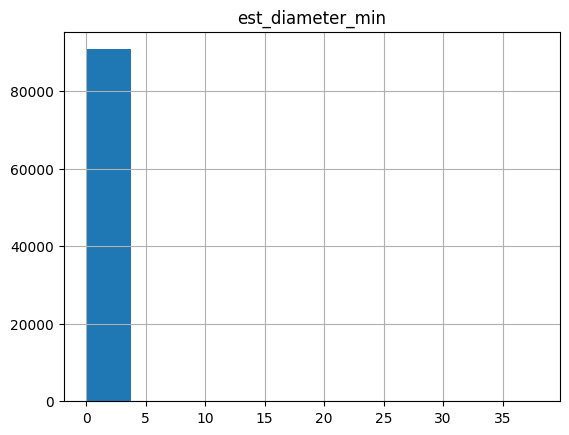

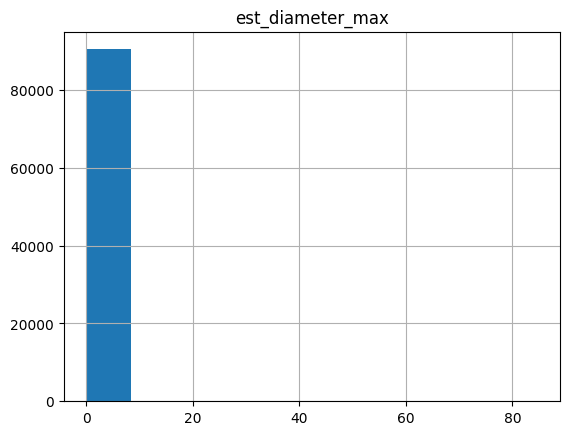

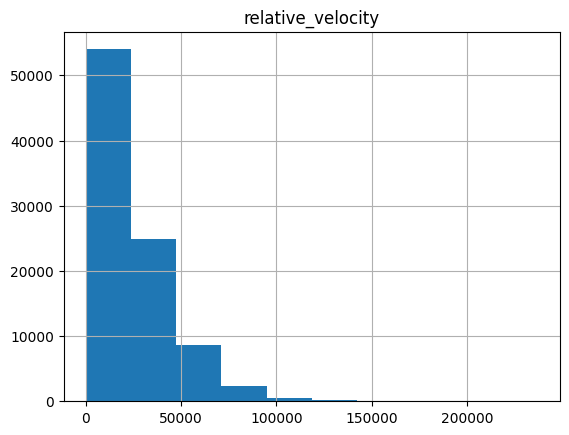

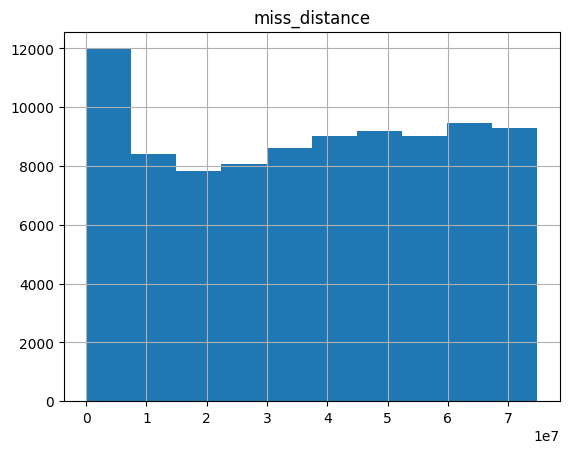

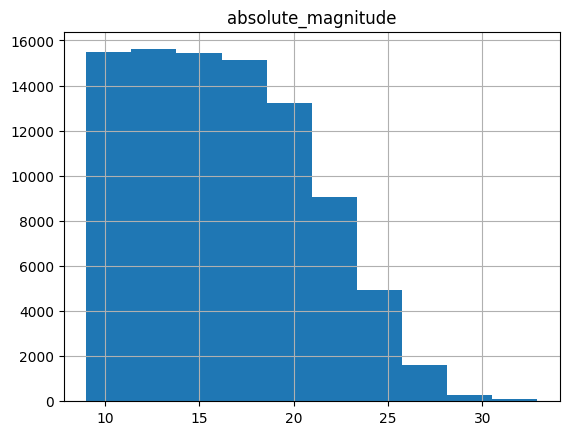

In [48]:
columns = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']


for column in columns:
    hazaurdous_obj.hist(column)

In [49]:
outlier = hazaurdous_obj[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
outlier

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.016016,0.012295,50156.232118,1.024333e+06,19.320459
1,0.030518,0.006012,6185.743238,3.268186e+07,11.416209
2,0.055533,0.113426,28419.989232,6.538636e+07,9.265849
3,0.019256,0.021329,38709.012702,1.260796e+07,21.105324
4,0.139494,0.210674,44519.283205,7.130590e+07,14.592539
...,...,...,...,...,...
90831,0.017561,0.009009,13598.884699,1.635007e+06,12.629370
90832,0.110804,0.091401,19141.801788,3.351901e+07,17.738194
90833,0.035039,0.066964,51168.509316,5.471396e+07,15.679649
90834,0.044112,0.088229,2042.931133,2.694877e+07,9.941953


In [50]:
Q1 = outlier.quantile(0.25)
Q1

est_diameter_min      1.925551e-02
est_diameter_max      1.514314e-02
relative_velocity     8.908694e+03
miss_distance         1.721082e+07
absolute_magnitude    1.250663e+01
Name: 0.25, dtype: float64

In [51]:
Q3 = outlier.quantile(0.75)
Q3

est_diameter_min      1.434019e-01
est_diameter_max      1.418593e-01
relative_velocity     3.437177e+04
miss_distance         5.654900e+07
absolute_magnitude    1.966501e+01
Name: 0.75, dtype: float64

In [52]:
IQR = Q3-Q1
hazaurdous_obj_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
hazaurdous_obj_filtered

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.016016,0.012295,50156.232118,1.024333e+06,19.320459
1,0.030518,0.006012,6185.743238,3.268186e+07,11.416209
2,0.055533,0.113426,28419.989232,6.538636e+07,9.265849
3,0.019256,0.021329,38709.012702,1.260796e+07,21.105324
4,0.139494,0.210674,44519.283205,7.130590e+07,14.592539
...,...,...,...,...,...
90831,0.017561,0.009009,13598.884699,1.635007e+06,12.629370
90832,0.110804,0.091401,19141.801788,3.351901e+07,17.738194
90833,0.035039,0.066964,51168.509316,5.471396e+07,15.679649
90834,0.044112,0.088229,2042.931133,2.694877e+07,9.941953


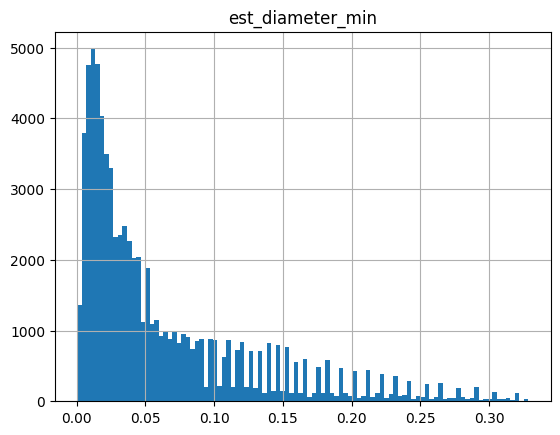

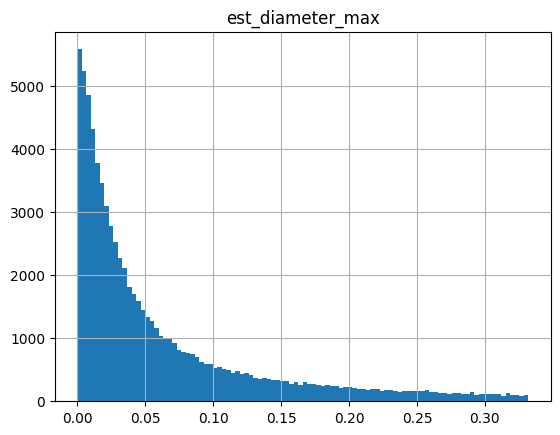

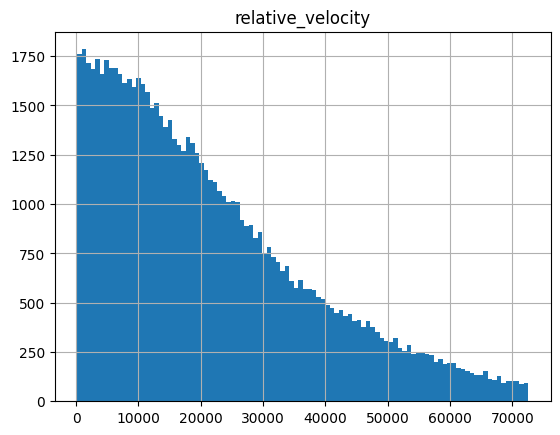

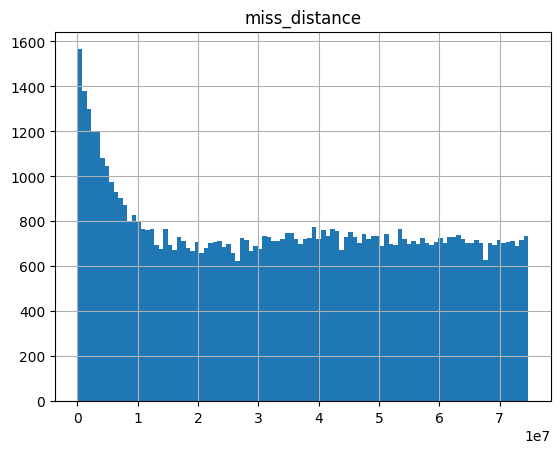

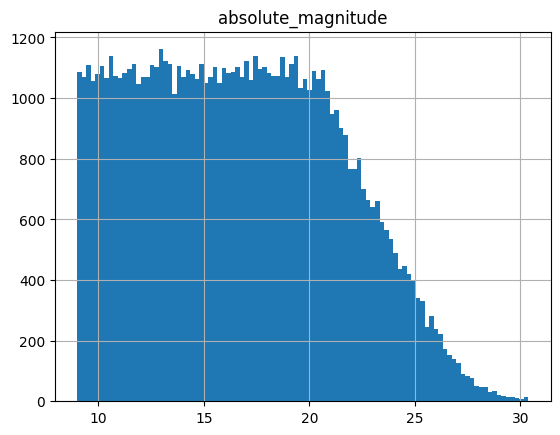

In [53]:
filtered_outlier = hazaurdous_obj_filtered[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]

for col in filtered_outlier:
    hazaurdous_obj_filtered.hist(col, bins=100)

In [54]:
hazaurdous_obj.loc[(hazaurdous_obj['hazardous'] == "True"), 'hazardous'] = 1
hazaurdous_obj.loc[(hazaurdous_obj['hazardous'] == "False"), 'hazardous'] = 0
hazaurdous_obj['hazardous'] = hazaurdous_obj['hazardous'].astype(float)

C:\Users\NoteBook\AppData\Local\Temp\ipykernel_26628\254499432.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  hazaurdous_obj.loc[(hazaurdous_obj['hazardous'] == "True"), 'hazardous'] = 1


C:\Users\NoteBook\Арина\учеба\labs\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\NoteBook\Арина\учеба\labs\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


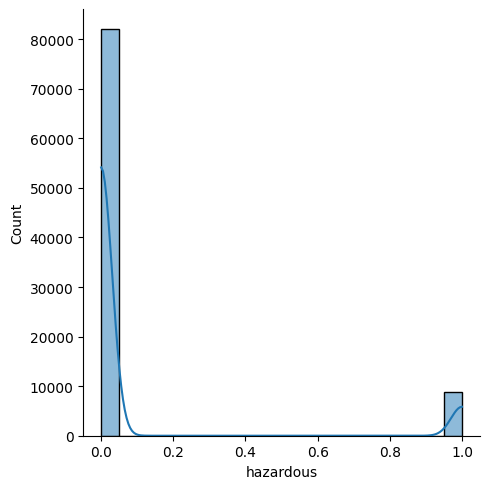

In [55]:
sns.displot(hazaurdous_obj["hazardous"],bins=20,kde=True);

In [56]:
scaler = StandardScaler()
hazaurdous_obj_col= hazaurdous_obj[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude', 'hazardous']]
hazaurdous_scaler = scaler.fit_transform(hazaurdous_obj_col.drop(['hazardous'], axis=1))

In [57]:
Y = hazaurdous_obj_col["hazardous"]
X = hazaurdous_obj_col
Y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
90831    0.0
90832    0.0
90833    0.0
90834    0.0
90835    0.0
Name: hazardous, Length: 90836, dtype: float64

In [58]:
X

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.012295,50156.232118,1.024333e+06,19.320459,0.0
1,0.030518,0.006012,6185.743238,3.268186e+07,11.416209,0.0
2,0.055533,0.113426,28419.989232,6.538636e+07,9.265849,0.0
3,0.019256,0.021329,38709.012702,1.260796e+07,21.105324,0.0
4,0.139494,0.210674,44519.283205,7.130590e+07,14.592539,0.0
...,...,...,...,...,...,...
90831,0.017561,0.009009,13598.884699,1.635007e+06,12.629370,0.0
90832,0.110804,0.091401,19141.801788,3.351901e+07,17.738194,0.0
90833,0.035039,0.066964,51168.509316,5.471396e+07,15.679649,0.0
90834,0.044112,0.088229,2042.931133,2.694877e+07,9.941953,0.0


In [60]:
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2) 
knn.fit(X_train, Y_train)

NameError: name 'X_train' is not defined

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=10) 
knn.fit(X_train, Y_train)

In [ ]:
y_bin_knn_pred = knn.predict(X_test)
y_bin_knn_pred

In [ ]:
confusion_matrix(Y_test, y_bin_knn_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_bin_knn_pred))

In [ ]:
from collections import Counter
Counter(Y_test)

In [ ]:
def accuracy_score(Y_test, y_bin_knn_pred):
    arr=confusion_matrix(Y_test, y_bin_knn_pred)
    TP=arr[0,0]
    FP=arr[0,1]
    FN=arr[1,0]
    TN=arr[1,1]
    return((TP+TN)/(TP+TN+FP+FN))

In [ ]:
def precision_score(Y_test, y_bin_knn_pred):
    arr=confusion_matrix(Y_test, y_bin_knn_pred)
    TP=arr[0,0]
    FP=arr[0,1]
    return(TP/(TP+FP))

In [ ]:
def recall_score(Y_test, y_bin_knn_pred):
    arr=confusion_matrix(Y_test, y_bin_knn_pred)
    TP=arr[0,0]
    FN=arr[1,0]
    return(TP/(TP+FN))

In [ ]:
def f1_score(Y_test, y_bin_knn_pred):
    multy=precision_score(Y_test, y_bin_knn_pred)*recall_score(Y_test, y_bin_knn_pred)
    sum=precision_score(Y_test, y_bin_knn_pred)+recall_score(Y_test, y_bin_knn_pred)
    return( 2*(multy/sum) )

In [ ]:
accuracy_score(Y_test, y_bin_knn_pred)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
%matplotlib inline

y_scores = knn.predict_proba(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(Y_test, y_scores[:,1])

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Нивный Байесовский классификатор

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred_NB = gnb.predict(X_test)
print(classification_report(Y_test, Y_pred_NB))

In [ ]:
accuracy_score(Y_test, Y_pred_NB)

In [ ]:
y_scores = knn.predict_proba(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(Y_test, y_scores[:,1])

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression


log = LogisticRegression(random_state=42).fit(X_train, Y_train)
Y_pred_log = log.predict(X_test)
log.score(X_train, Y_train)
print(classification_report(Y_test, Y_pred_log))

In [ ]:
accuracy_score(Y_test, Y_pred_log)

In [ ]:
y_scores = knn.predict_proba(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(Y_test, y_scores[:,1])

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Итоговая модель классификаторов

In [ ]:
classifiers = {
    'SVC': clf,
    'KNN classifier': knn,
    'Logistic Regression': log,
    'Gaussian NB': gnb,
}
list = [Y_pred_sv, y_bin_knn_pred, Y_pred_log, Y_pred_NB]
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    accuracy = accuracy_score(Y_test, list[index])
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(Y_test,list[index]))